## Introduction

This tutorial will introduce you to the basics of A/B testing, focussing on analyzing results of an actual A/B test. This is a very important concept in the data science world especially when companies want to implement product changes, UI changes and understand how end users are responding to it. Users are randomly split into two groups - Control and Experimental. The Control group is exposed to the existing design/framework and the Experiment group is exposed to the modified one. We then go on to analyze how the two groups react to these changes and whether the change was significant or not.

### Contents

We will be working with a dataset containing the results of an A/B Test. Following are the indexable contents of the tutorial:

- [Understanding the A/B Test that was Performed](#Understanding-the-A/B-Test-that-was-Performed)

- [Exploring, Preprocessing and Visualizing the AB Test Results](#Exploring,-Preprocessing-and-Visualizing-the-AB-Test-Results)

- [Hypothesis Testing](#Hypothesis-Testing)

- [Performing a T Test for sum_gamerounds](#Performing-a-T-Test-for-sum_gamerounds)

- [Performing a T Test for 1 Day Retention](#Performing-a-T-Test-for-1-Day-Retention)

- [Performing a T Test for 7 Day Retention](#Performing-a-T-Test-for-7-Day-Retention)

- [CHI SQUARE TEST](#CHI-SQUARE-TEST)

- [Summary and References](#Summary-and-References)



## Understanding the A/B Test that was Performed

The dataset we will be working with is sourced from

https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/data

This dataset is derived from a mini-project on www.datacamp.com

The data is from an AB test conducted in the "Cookie Cats" game a popular mobile game developed by Tactile Entertainment
Here is a short description of the game (quoting directly from the kaggle link)

_It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats.As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged._


The objective of this AB test was to understand where the gates can be placed and how does that affect player activity (does it retain players or negatively effect)
The gate was initially at level 30 and was shifted up to level 40. This formed the two distinct groups for the AB Test. There was one group that played the game with the gate at level 30 and another group og users that played the game at level 40
Following is data collected regarding their activity and retention after this change was implemented

In [1]:
#importing all the necessary packages
import pandas as pd
import numpy as np
import math
import scipy.stats
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [2]:
df=pd.read_csv("cookie_cats.csv")
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


We have a total of 5 columns in our dataset namely:

1) userid - the unique id given to the user

2) version - this field tells us which group the user belongs to (gate_30 or gate_40)

3) sum_gamerounds - this field describes the number of game rounds played by the user in the first 14 days after installation of 
                    the game
                    
4) retention_1 - Did the player return back and play 1 day after installation

5) retention_7 - Did the player return back and play 7 days after installation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## Exploring, Preprocessing and Visualizing the AB Test Results

Before we move into performing the actual Hypothesis Tests it is necessary to do some Exploratory Data Analysis to understand our data and the practical relevance of the each column. Exploring the data will point us in thr right direction and will help to draw better conclusions from the hypothesis tests that we perform later


In [4]:
#checking for missing values
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [5]:
#checking for duplicate rows
df[df.duplicated()]

,userid,version,sum_gamerounds,retention_1,retention_7


In [6]:
#checking the statistical spread of the data
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


gate_30         AxesSubplot(0.1,0.15;0.363636x0.75)
gate_40    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

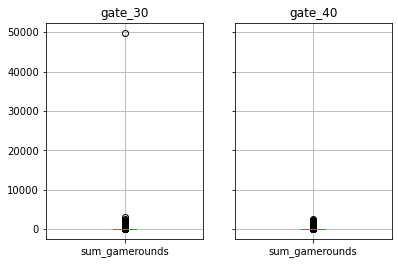

In [7]:
df.groupby('version').boxplot(column="sum_gamerounds")

gate_30         AxesSubplot(0.1,0.15;0.363636x0.75)
gate_40    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

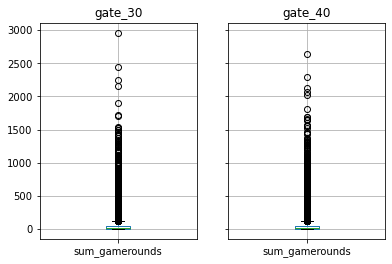

In [8]:
df = df[df['sum_gamerounds'] < 10000]
df.groupby('version').boxplot(column="sum_gamerounds")

version
gate_30    AxesSubplot(0.125,0.125;0.775x0.755)
gate_40    AxesSubplot(0.125,0.125;0.775x0.755)
Name: sum_gamerounds, dtype: object

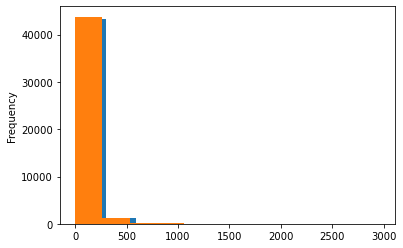

In [9]:
df.groupby('version').sum_gamerounds.plot(kind='hist')

When we can infer from the summary statistics, distribution and boxplot of sum_gamerounds that most users played very few rounds after installation as the 75th percentile itself is at 51 max value is at 2961. 50% of users just played 16 rounds. The data for this metric is highly skewed and would not be a great field to be used in AB Testing analysis

In [10]:
df.groupby('version')['sum_gamerounds'].count()

version
gate_30    44699
gate_40    45489
Name: sum_gamerounds, dtype: int64

In [11]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [12]:
t1=df.groupby('version').retention_1.value_counts()
t1

version  retention_1
gate_30  False          24665
         True           20034
gate_40  False          25370
         True           20119
Name: retention_1, dtype: int64

In [13]:
t2=df.groupby('version').userid.count()
t2

version
gate_30    44699
gate_40    45489
Name: userid, dtype: int64

In [14]:
t3=df.groupby('version').retention_7.value_counts()
t3

version  retention_7
gate_30  False          36198
         True            8501
gate_40  False          37210
         True            8279
Name: retention_7, dtype: int64

In [15]:
print("Percent of users who played the game 1 day after installation - Gate 30 : "+str(t1[1]/t2[0]*100))
print("Percent of users who played the game 1 day after installation - Gate 40 : "+str(t1[3]/t2[1]*100))

Percent of users who played the game 1 day after installation - Gate 30 : 44.81979462627799
Percent of users who played the game 1 day after installation - Gate 40 : 44.22827496757458


In [16]:
print("Percent of users who played the game 7 days after installation - Gate 30 :"+str(t3[1]/t2[0]*100))
print("Percent of users who played the game 7 days after installation - Gate 40 :"+str(t3[3]/t2[1]*100))

Percent of users who played the game 7 days after installation - Gate 30 :19.018322557551624
Percent of users who played the game 7 days after installation - Gate 40 :18.200004396667328


From our EDA we observe that gate 30 (the existing gate) seems to be performing better than gate 40 on all the 3 metrics and it might not make sense to move up the gate to level 40 after all. We will perform statistical tests to confirm this conclusion

## Hypothesis Testing

Hypothesis Testing is a statistical test in which you evaluate data to try to come to a conclusion about an alternate hypothesis that you have proposed. First we need to define what Null and Alternate hypothesis are.
Null Hypothesis is basically the ground truth that we know and exists with proof, while an Alternate hypothesis is a new truth that we are trying to prove by rejecting the Null Hypothesis. Null Hypotheis is represented by $H_{0}$ and Alternate Hypothesis is represented by $H_{1}$

We have two groups - Control (Null Hypothesis) and Experiment (Alternate Hypothesis). We have two data on how users have behaved, how often have they come back to play the game for both these hypotheses. We will check whether moving the gate upto level 40 made any difference at all, for the different metrics that we have. In this tutorial we will learn how to perform a T-test/Z-Test and Chi-Sqaure test from scratch

### 2 Sample T/Z-Test 

If you want to check whether there is any statistical difference between 2 samples of data we perform a T/Z test. When the sample size is less than 30 it is typically called a T-test and a Z-test when the sample size is greater than 30
Depending on whether the data is numerical or proportional we compute the t-statistic and compare that to the critical value (will deep dive into this while performing the actual test). From the t-statistic we compute the pvalue to check whether our result is enough statistically significant so as to reject the Null hypothesis and accept the alternate one

Some assumptions:
- We are performing a one tailed test as we already have an idea of the direction in which our ab test results are
- For a sample size greater than 30 we use a z score. Typically a zscore and tscore is the same for a sample size greater than 30. The reason t-score is specficially used for a sample size<30 is because under such a condition the Central Limit Theorem might not hold true and the t-score corrects the z-score to give a better picture. For this tutoiral's purpose we will stick to the terminology of a t-score for simplicity of understanding


## Performing a T Test for sum_gamerounds

From our EDA we realized that sum_gamerounds might not be the best field to check the effectiveness of our AB Test as most users end up not playing the game after installation. However I have included this in the tutorial as it is the only numerical field and it is important to understand how to carry out a hypothesis test for a numerical field.

The first step is to define the Null and Alternate Hypothesis represented by $ H_{0} $ and $ H_{1} $ respectively

$ H_{0} $ : There is no difference between avg number of rounds between the two groups

$ H_{1} $ : Avg number of rounds are lower when the gate is placed at level 40

We then go on to compute the mean $\mu_{0}$ of the control data and the mean $\mu_{1}$ of the experiment data. The t-statistic measures how far the estimated mean is from the existing mean, in effect informing us whether our experiment was successful. SE is the standard error of the difference of the two populations. 

It is given by t-stat = $\frac{\mu_{1}-\mu_{0}}{SE}$

Some other defintions of terms used in the subsequent test:

- Critical Value: It is point on the t distribution which serves as a benchmark to understand whether we have enough significance to reject the null hypothesis. We can safely reject a null hypothesis if the t-statistic is greater than the critical value


- Confidence Level: It is the portion of the t-distribution where any point that lies, fails to reject the null hypothesis. For a confidence level of 95%, the significance level is 5% which means that a point lying in the significant region can reject the null hypothesis 


- P Value: It is the probability of a point lying in the tails of a t-distribution (in the significant area). Typically a p-value less than equal to 0.05 means our result is significant.


- Degrees of Freedom: The number of pieces of information that are free/independent and contribute into estimate calculation. In our case it is N1 + N2 - 2

When we perform the t-tests for the retention variables we will try to visualize a t-distribution to gain further understanding of all these parameters

In [17]:
X=df[df['version']=="gate_30"]['sum_gamerounds']
Y=df[df['version']=="gate_40"]['sum_gamerounds']

In [18]:
#u1 and u2 are the mean values of the null and alt. hypothesis
u1=X.mean()
u2=Y.mean()

#sd1 and sd2 are the standard deviation values that we will use to compute SD of difference
sd1=X.std()
sd2=Y.std()

In [19]:
#Calculating individual standard errors and standard error of the difference
XSE,YSE = sd1/math.sqrt(len(X)),sd2/math.sqrt(len(Y))
DSE = math.sqrt(XSE**2+YSE**2)

In [20]:
t_score=(u1-u2)/DSE

In [21]:
degrees_of_freedom=len(X)+len(Y)-2

In [22]:
pvalue=1-scipy.stats.t.cdf(abs(t_score), degrees_of_freedom)
pvalue2=scipy.stats.t.sf(abs(t_score), degrees_of_freedom)

Performing a hypothesis test for Retention1

In [23]:
pvalue,t_score

(0.47473431077112027, 0.06337426312891958)

Here we get a pvalue greater than 0.05, while that means we fail to reject the null hypothesis, in this particular metric we must take it with a grain of salt as from our EDA we realized that the metric itself is not very significant given how skewed the data is. 

## Performing a T Test for 1 Day Retention

The first step is to define the Null and Alternate Hypothesis represented by $ H_{0} $ and $ H_{1} $ respectively

$ H_{0} $ : There is no difference in the proportion of users coming back to play the game after 1 day, when we change the gates

$ H_{1} $ : The number of users coming back to play the game after 1 day is lesser when the gate is at level 40

This is different from the previous test as we are now comparing two categorical populations rather than numerical populations. While comparing two proportions the standard error is computed by square-rooting the pooled variance of the two samples.

SE = $\sqrt{\hat{p}*(1-\hat{p})*(\frac{1}{N1}+\frac{1}{N2})}$

$p{1}$ is the proportion from our Experiment group and $p{0}$ is out proportion from the Control Group
 
t-stat = $\frac{p_{1}-p_{0}}{SE}$



In [24]:
n1=len(df[df['version']=="gate_30"])
n2=len(df[df['version']=="gate_40"])

In [25]:
#computing the value counts 
t1=df.groupby('version').retention_1.value_counts()
t2=df.groupby('version').userid.count()

In [26]:
t1

version  retention_1
gate_30  False          24665
         True           20034
gate_40  False          25370
         True           20119
Name: retention_1, dtype: int64

In [27]:
#p1 and p2 are the proportions from our two samples
p1=t1[1]/n1
p2=t1[3]/n2

In [28]:
p1,p2

(0.4481979462627799, 0.44228274967574577)

In [29]:
#computing the pooled variance of the two samples
pcap=(t1[1]+t1[3])/(n1+n2)

In [30]:
#getting the standard error from the pooled variance
se=math.sqrt(pcap*(1-pcap)*((1/n1)+(1/n2)))
se

0.0033099350735518005

In [31]:
#finding the t score from the formula
t_score=(p2-p1)/se

In [32]:
t_score

-1.787103509763628

In [33]:
degrees_of_freedom=n1+n2-2

In [34]:
#computing pvalues using two different methods - using cdf and sf (survival function)
pvalue=1-scipy.stats.t.cdf(abs(t_score), degrees_of_freedom)
pvalue2=scipy.stats.t.sf(abs(t_score), degrees_of_freedom)

In [35]:
# calculate the critical value
significance = 0.05
tcrit = t.ppf(1.0 - significance, degrees_of_freedom)
tcrit

1.6448705229763008

In [36]:
pvalue,pvalue2

(0.03696205878476111, 0.03696205878476109)

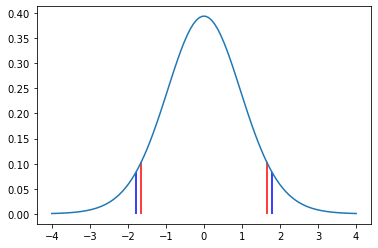

In [37]:
#visulaizing our results in the form of a t distribution
xs = np.linspace(-4,4,100)
plt.vlines([-tcrit, tcrit], 0.0, t.pdf(tcrit,20),colors='r')
plt.vlines([-t_score,t_score],0.0,t.pdf(t_score,20),colors="b")
plt.plot(xs, t.pdf(xs,20))

This is visual representation for understanding and is not generated from the actual data. While we are performing one-tailed test I have marked critical values and t-scores on both sides of the distribution for understanding purpose. 

Here our critical value is marked in red and the t-score is marked in bue. The region of the plot lying beyond the red line i.e the critical value is the region where we can reject the null hypothesis. The pvalue is basically the area of the region of the tails (beyond the red line). The red lines (critical values) are decided by the significance level (alpha) that we choose and hence we compare the pvalue to 0.05

Please note that the pvalue of 0.036 that we got is the area of the left tail. In a two tailed test (when we are just checking an eqaulity condition) the pvalue needs to be doubled to account for both the tails

Conclusion from T-test:

We get a t-statistic of -1.78 which is less than the critical value (left-tailed test) and the pvalue we get is 0.036 which is less than 0.05 (95% confidence level)
Therefore we can reject the null hypothesis and we come to the conclusion that shifting the gate to level 40 was not a great idea after all

## Performing a T Test for 7 Day Retention

The first step is to define the Null and Alternate Hypothesis represented by $ H_{0} $ and $ H_{1} $ respectively

$ H_{0} $ : There is no difference in the proportion of users coming back to play the game after 7 day, when we change the gates

$ H_{1} $ : The number of users coming back to play the game after 7 day is lesser when the gate is at level 40

The formulas for Standard Error and the t-statistic remain the same as the previous example given that this too is an example of comparing proportions from 2 samples


In [38]:
t3=df.groupby('version').retention_7.value_counts()
t3

version  retention_7
gate_30  False          36198
         True            8501
gate_40  False          37210
         True            8279
Name: retention_7, dtype: int64

In [39]:
#p1 and p2 are the proportions from our two samples
p1=t3[1]/n1
p2=t3[3]/n2

In [40]:
#computing the pooled variance of the two samples
pcap=(t1[1]+t1[3])/(n1+n2)

In [41]:
#getting the standard error from the pooled variance
se=math.sqrt(pcap*(1-pcap)*((1/n1)+(1/n2)))
se

0.0033099350735518005

In [42]:
#finding the t score from the formula
t_score=(p2-p1)/se

In [43]:
t_score

-2.4723087997196913

In [44]:
degrees_of_freedom=n1+n2-2

In [45]:
#computing pvalues using two different methods - using cdf and sf (survival function)
pvalue=1-scipy.stats.t.cdf(abs(t_score), degrees_of_freedom)
pvalue2=scipy.stats.t.sf(abs(t_score), degrees_of_freedom)

In [46]:
# calculate the critical value
significance = 0.05
tcrit = t.ppf(1.0 - significance, degrees_of_freedom)
tcrit

1.6448705229763008

In [47]:
pvalue,pvalue2

(0.006713090405126465, 0.006713090405126392)

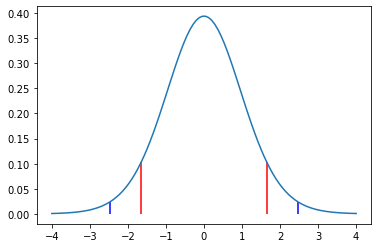

In [48]:
#visulaizing our results in the form of a t distribution
xs = np.linspace(-4,4,100)
plt.vlines([-tcrit, tcrit], 0.0, t.pdf(tcrit,20),colors='r')
plt.vlines([-t_score,t_score],0.0,t.pdf(t_score,20),colors="b")
plt.plot(xs, t.pdf(xs,20))

In the above representation of the t-distribution we see that the t-score (shown by the blue line) lies way beyond the critical value (shown by the red line) in the significant region. This is also cemented by the pvalue of 0.0066 that we got
Again this is a one-tailed test but the representation has both tails visualized for understanding purposes

We get a t-statistic of -2.47 which is less than the critical value (left-tailed test) and the pvalue we get is 0.0066 which is less than 0.05 (95% confidence level)
Therefore we can reject the null hypothesis and we come to the conclusion that shifting the gate to level 40 was not a great idea after all

## CHI SQUARE TEST

In a Chi Square test we compare two distributions of categorical data are related to each other ; whether they are independent or dependent on each other. The Chi Square test starts with an assumption that the observed frequency of our control data matches the expected frequencies (from our experimental data). In the case of 1 day rentention we observed that there was a slight increase in percentage of users coming back after the gate was shifted to level 40. The t-test helped us reject the null hypothesis and we perform the Chi-square test to further solidify our analysis

$ H_{0} $ : Observed and Expected frequencies are same i.e no diffference in user retention between gate 30 and gate 40

$ H_{1} $ : Observed and Expected frequencies are different i.e there is difference in user retention between gate 30 and 40

The Chi Square statistic is computed by the following equation

${\chi}^2=\sum_{i,j}^{n} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}\$

We then compare the computed chi-sq statistic to the critical value (or we compare the pvalue with alpha) to decide whether to reject/fail to reject the null hypothesis

In [49]:
#using the numbers from the true-false distribution, ct represents contingency table
ct=[[20034,24665],[20119,25730]]
ct

[[20034, 24665], [20119, 25730]]

In [50]:
#using the chi2_contingency package from scipy
chi_sq, pvalue, dof, expected = chi2_contingency(ct)
chi_sq,pvalue,dof,expected

(8.0444307701523,
 0.004564375882352519,
 1,
 array([[19821.51949242, 24877.48050758],
        [20331.48050758, 25517.51949242]]))

In [51]:
#manually computing the chi-squared statistic to understand better
a=ct[0][0]
b=ct[0][1]
c=ct[1][0]
d=ct[1][1]
sum=ct[0][0]+ct[0][1]+ct[1][0]+ct[1][1]
E1=((a+b)*(a+c))/sum
E2=((b+a)*(b+d))/sum
E3=((c+a)*(c+d))/sum
E4=((d+c)*(d+b))/sum
Act=np.array([a,b,c,d])
Exp=np.array([E1,E2,E3,E4])
chi_sq1=np.sum(np.square(Act-Exp)/Exp)

In [52]:
#we check the manually computed chi-sq statistic to see if it matches the one we got from scipy
chi_sq1

8.082424442738485

In [53]:
prob=0.95
print("chi_sq:"+str(chi_sq)+" critical value: "+str(chi2.ppf(prob, dof)))

chi_sq:8.0444307701523 critical value: 3.841458820694124


In [54]:
alpha = 1.0 - prob
print("pvalue: "+str(pvalue)+" alpha: "+str(alpha))

pvalue: 0.004564375882352519 alpha: 0.050000000000000044


We see that the chi sqaure statistic is greater than the critical value and the pvalue is below 0.05
Therefore we can conclude that the observed and expected frequencies are dependent, hence rejecting the null hypothesis

### A small note on type 1 & 2 errors

Statistical tests depend on the data/experiment and are vulnerable to errors. Many times the result we get in Hypothesis Tests maybe the exact opposite of what is happening and it is important to know about these errors while stepping into A/B Testing.
There are 2 kinds of errors possible when carrying out a Hypothesis Test:

1) Type 1 Error: 

Rejecting a true null. This means that the null hypothesis was actually true but we rejected it by mistake. In the cookie cats case it translates to "Moving the gate to level 40 actually did not make a difference but we hypothesized that it reduced the retention rate". The probability of making a type 1 error is $\alpha$ (the significance level)

2) Type 2 Error:

Failing to reject a false null. This means that the null hypothesis was actually not true but we failed to reject it. In the cookie cats case it tranlsates to "Moving the gate to level 40 actually did lead to a lessened retention rate but we failed to identify this and potentially lost users". The probability of making a type 2 error is given by $\beta$ and depends on how far the true mean is from the null mean

Type 1 and 2 errors is a very interesting concept and can be read about more. I have included a link in the references for further readings on this topic

## Summary and References

This tutorial gave an introduction to evaluating results of an AB Test and covered performing of statistical tests from scratch in python. Of course there are many other techniques out there for AB Testing and this tutorial can serve as a starting point for the same. Here are some useful references for the content covered in the tutorial and starting points to dive deeper into the world of AB Testing:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/data

https://towardsdatascience.com/simple-and-complet-guide-to-a-b-testing-c34154d0ce5a

https://towardsdatascience.com/type-i-and-type-ii-errors-of-hypothesis-tests-understand-with-graphs-43079fdd936a


